In [1]:
import matplotlib.pyplot as plt, numpy as np, numpy.random as npr, csv
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import LocallyLinearEmbedding
from tqdm import trange
#%matplotlib notebook
%matplotlib inline
import torch.nn as nn, timeit, torch, pystan as ps
from time import time
import matplotlib.pyplot as plt
from pylab import plot, show, legend

In [2]:
sm_refpoints = ps.StanModel(file="stan_files/nn_refpoints_constrainedtheta.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1353f276aea75936809a10908ae18718 NOW.


In [3]:
M = 1000
Z = 10*npr.rand(2,M)
X = np.zeros((3,M))
X[0] = np.cos(Z[0])*np.cos(Z[1])
X[1] = np.cos(Z[0])*np.sin(Z[1])
X[2] = np.sin(Z[0])

idx = X[2]>0
X = X[:,idx]
Z = Z[:,idx]
X += 0.1*npr.rand(*np.shape(X))
Nobs = np.shape(Z)[1]

In [4]:
Nobs

627

### Local linear embedding for reference points:

In [22]:
n_ref = 40
ref_points = npr.choice(Nobs,n_ref,replace=False)
embedding = LocallyLinearEmbedding(n_components=2,n_neighbors=10)
X_embedded = embedding.fit_transform(X.transpose()).transpose()

In [23]:
train = np.setdiff1d(np.arange(Nobs), ref_points)
X_ref = X[:,ref_points]
Z_ref = X_embedded[:,ref_points]
X_train = X[:,train]

In [24]:
n_in = np.shape(X_embedded)[0]
n_h = 50
n_out = np.shape(X)[0]

model = nn.Sequential(nn.Linear(n_in, n_h),
                      nn.Tanh(),
                      nn.Linear(n_h, n_out))

In [25]:
def init_normal(m):
    if type(m) == nn.Linear: nn.init.normal_(m.weight)
model.apply(init_normal)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, nesterov=True)

In [26]:
n_iter = 50_000
start = time()
for epoch in range(n_iter):
    X_pred = model(torch.from_numpy(Z_ref.transpose().astype(np.float32)))
    loss = criterion(X_pred, torch.from_numpy(X_ref.transpose().astype(np.float32)))
    if (epoch+1)%(n_iter/10) == 0 :
        print("Epoch: %d; loss: %.3f; time: %.1f mins" % (epoch+1, loss.item(), (time()-start)/60))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch: 5000; loss: 0.097; time: 0.0 mins
Epoch: 10000; loss: 0.097; time: 0.0 mins
Epoch: 15000; loss: 0.096; time: 0.1 mins
Epoch: 20000; loss: 0.096; time: 0.1 mins
Epoch: 25000; loss: 0.096; time: 0.1 mins
Epoch: 30000; loss: 0.096; time: 0.1 mins
Epoch: 35000; loss: 0.096; time: 0.2 mins
Epoch: 40000; loss: 0.096; time: 0.2 mins
Epoch: 45000; loss: 0.096; time: 0.2 mins
Epoch: 50000; loss: 0.096; time: 0.2 mins


In [27]:
for (i,p) in enumerate(model.parameters()):
    if i == 0 : W_1_optim = p.data;
    print(np.shape(p))

torch.Size([50, 2])
torch.Size([50])
torch.Size([3, 50])
torch.Size([3])


In [28]:
c = [np.linalg.norm(W_1_optim[i,:]) for i in range(n_in)]
for i in range(n_ref) : Z_ref[:,i] *= c

In [29]:
data = dict(Nobs=Nobs, 
              in_dim=np.shape(Z)[0], 
              out_dim=np.shape(X)[0], 
              hidden_dim=n_h,
              n_ref=np.shape(X_ref)[1],
              X=X_train, 
              X_ref=X_ref,
              Z_ref=Z_ref)

### Run Stan:

In [30]:
# control = dict(adapt_delta=0.9, max_treedepth=12)
start = time()
fit = sm_refpoints.sampling(data=data, thin=1, n_jobs=8, chains=8,
                            init="random", iter=1_000)#, control=control)
print(round((time()-start)/60,2), "minutes to run")
print(fit);

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


63.46 minutes to run
Inference for Stan model: anon_model_1353f276aea75936809a10908ae18718.
8 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
X[1,1]               0.17    0.08   0.61  -0.99  -0.26   0.17   0.57   1.36     55   1.16
X[2,1]              -0.12    0.07   0.47  -1.01  -0.45  -0.13    0.2   0.81     44   1.09
X[3,1]               0.33    0.35   0.86  -1.44  -0.31   0.53   0.97   1.65      6   1.83
X[4,1]               0.35    0.37    0.9  -1.53   -0.3   0.57   1.01   1.69      6   1.92
X[5,1]                0.1    0.06   0.46   -0.8  -0.21    0.1   0.41   0.99     52   1.06
X[6,1]               0.25    0.17   0.59  -0.95  -0.13   0.28   0.67   1.32     12   1.27
X[7,1]               0.03  6.7e-3   0.44  -0.81  -0.27   0.03   0.34    0.9   4352   1.01
X[8,1]               0.89    0.77   1.62  -2.42   0.09   1.59    2.0   2

In [31]:
trace = fit.extract()
n_samples = np.shape(trace['Z'])[0]
n_latent = np.shape(trace['Z'])[1]

### Traceplots of latent variables:

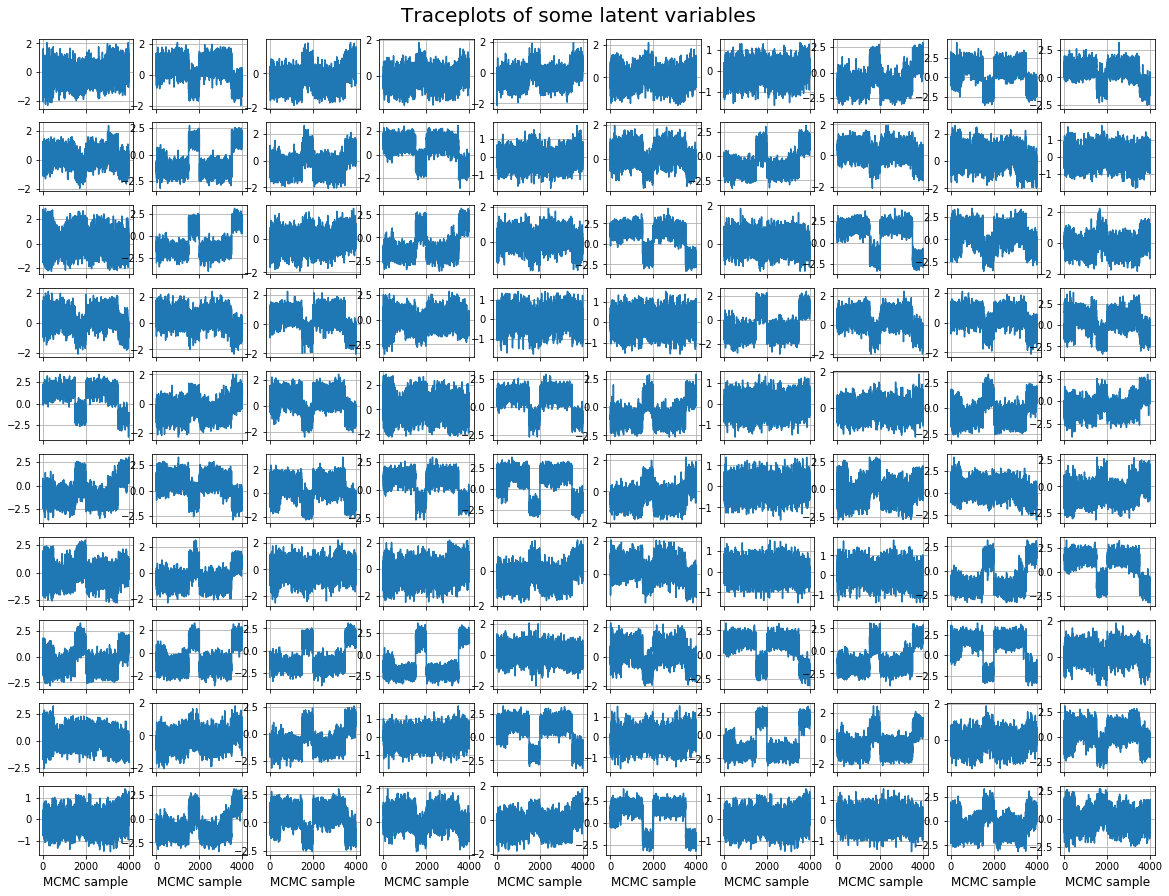

In [56]:
plt.figure(figsize=(20,15))
idx = npr.choice(n_latent,100).reshape(10,10)

for i in range(10):
    for j in range(10):
        k = 10*i+j
        plt.subplot(10,10,k+1)
        plt.plot(trace['Z'][:,idx[i,j],0])
        if i < 9 : plt.xticks(alpha=0)
        if i == 9 : plt.xlabel("MCMC sample", fontsize=12)
        plt.grid(True)
plt.suptitle("Traceplots of some latent variables", fontsize=20, x=0.5,y=0.91)
plt.show()

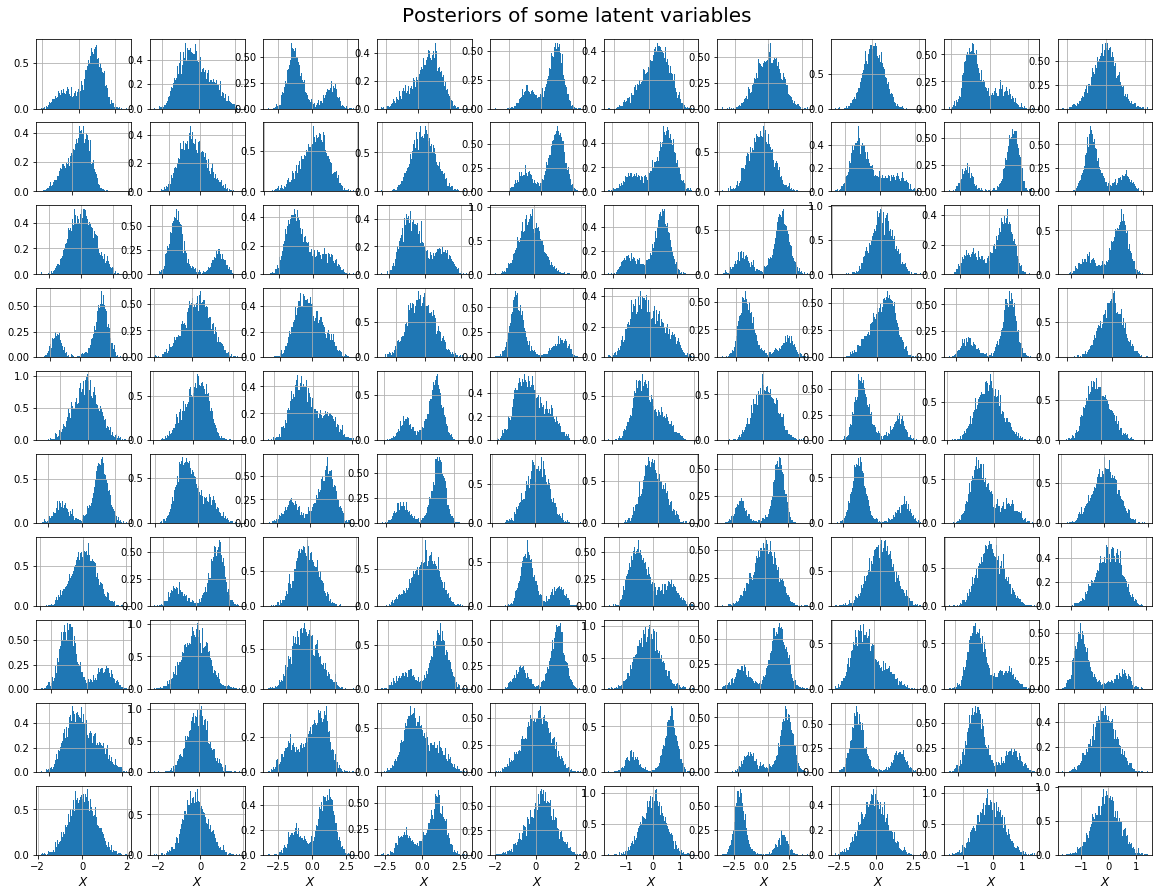

In [50]:
plt.figure(figsize=(20,15))
idx = npr.choice(n_latent,100).reshape(10,10)

for i in range(10):
    for j in range(10):
        k = 10*i+j
        plt.subplot(10,10,k+1)
        plt.hist(trace['Z'][:,idx[i,j],0], bins=100, density=True)
        if i < 9 : plt.xticks(alpha=0)
        if i == 9 : plt.xlabel(r"$Z$", fontsize=12)
        plt.grid(True)
plt.suptitle("Posteriors of some latent variables", fontsize=20, x=0.5,y=0.91)
plt.show()

### Loss:

In [33]:
def L2_loss(X, Z, weights_1, bias_1, weights_2, bias_2) :
    X_pred = np.matmul(np.tanh(np.matmul(Z,weights_1)+bias_1), weights_2) + bias_2
    return np.mean(np.sum((X-X_pred)**2,axis=1))

100%|██████████| 4000/4000 [00:02<00:00, 1939.70it/s]


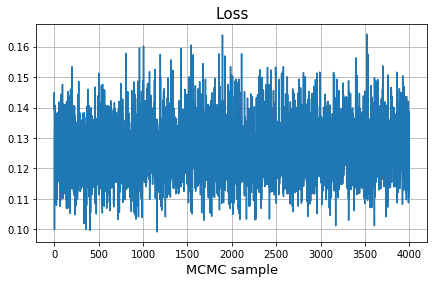

In [34]:
loss = np.zeros(n_samples)
for i in trange(n_samples) :
    loss[i] = L2_loss(X_train.transpose(), trace['Z'][i], trace['weights_1'][i], 
                      trace['bias_1'][i], trace['weights_2'][i], trace['bias_2'][i])
plt.figure(figsize=(7,4))
plt.plot(loss)
plt.title("Loss", fontsize=15)
plt.xlabel("MCMC sample", fontsize=13)
plt.grid(True)
plt.savefig('plots/loss_constrainedtheta_refpoints.pdf', dpi=1000, bbox_inches='tight');

### Pairwise distances:

In [35]:
k_max = 50

pw_dist_matrix = np.zeros((n_latent,n_latent,n_samples))
for i in trange(k_max) :
    for j in range(k_max) :
        for k in range(n_samples) :
            pw_dist_matrix[i,j,k] = np.linalg.norm(trace['Z'][k,i]-trace['Z'][k,j])

100%|██████████| 50/50 [00:49<00:00,  1.04it/s]


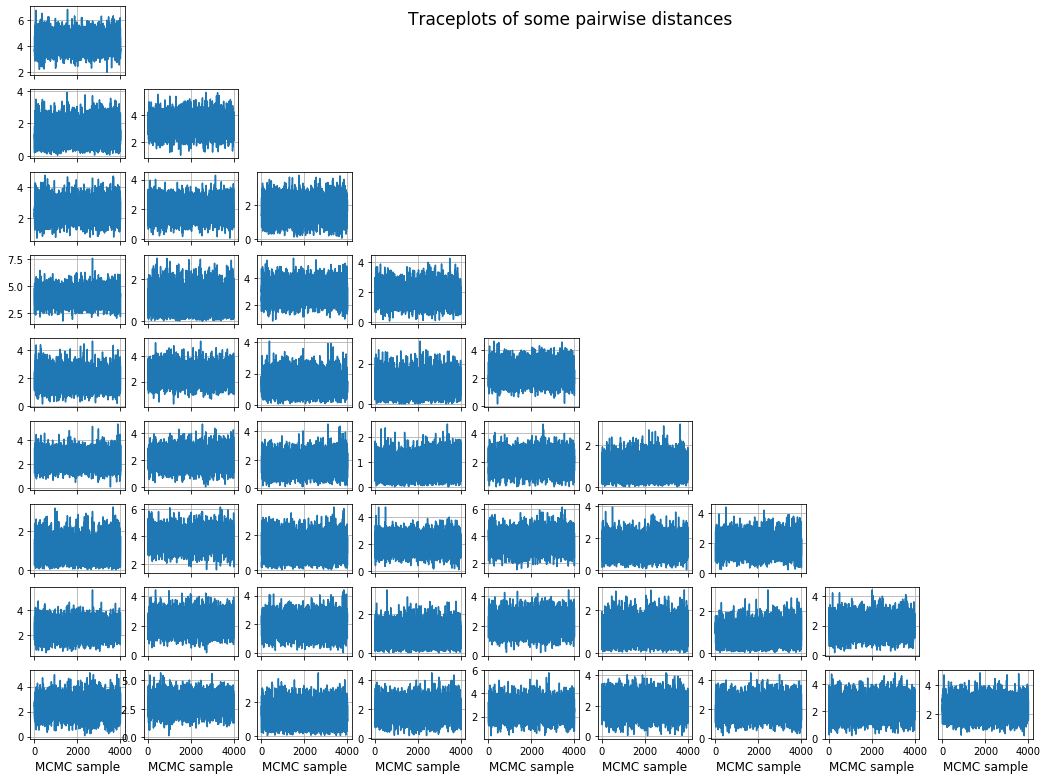

In [57]:
idx = npr.choice(k_max,10,replace=False)
plt.figure(figsize=(20,15))
for i in range(10):
    for j in range(10):
        if i > j :
            k = 10*i+j+1
            plt.subplot(10,10,k)
            plt.plot(pw_dist_matrix[idx[i],idx[j]])
            if i < 9 : plt.xticks(alpha=0)
            plt.grid(True)
            if i == 9 : plt.xlabel("MCMC sample", fontsize=12)
plt.suptitle("Traceplots of some pairwise distances", fontsize=17, x=0.5,y=0.8)
plt.savefig('plots/pw_dist_constrainedtheta_refpoints.pdf', dpi=200, bbox_inches='tight');

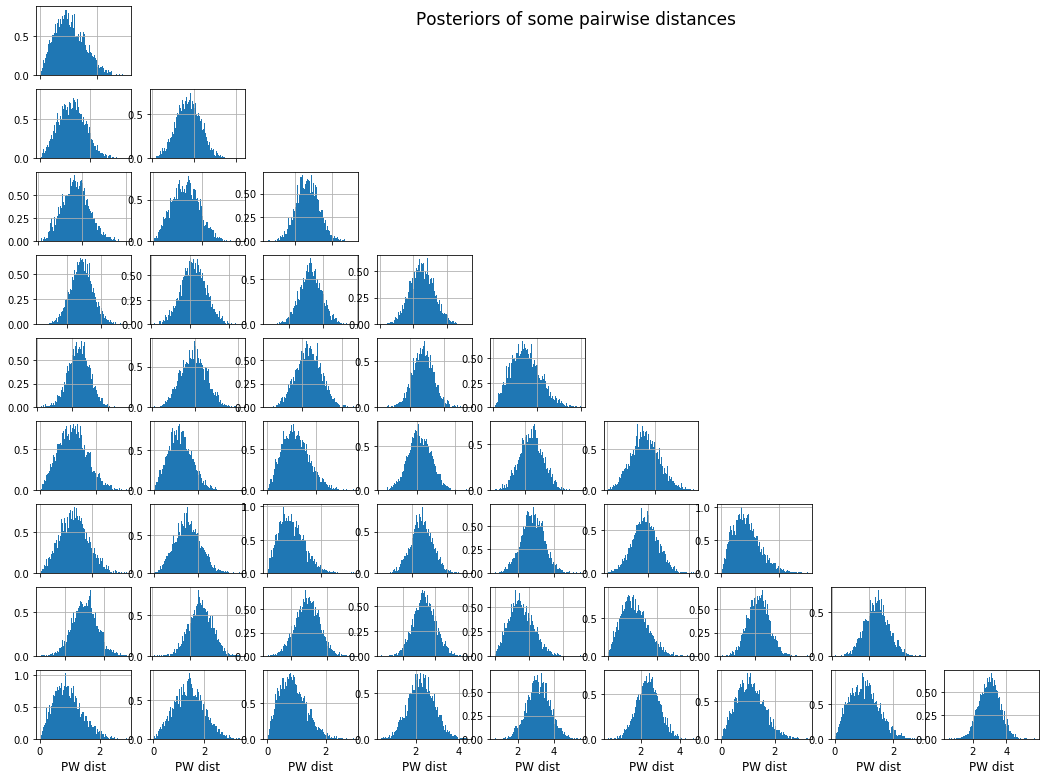

In [55]:
idx = npr.choice(k_max,10,replace=False)
plt.figure(figsize=(20,15))
for i in range(10):
    for j in range(10):
        if i > j :
            k = 10*i+j+1
            plt.subplot(10,10,k)
            plt.hist(pw_dist_matrix[idx[i],idx[j]], bins=100, density=True)
            if i < 9 : plt.xticks(alpha=0)
            plt.grid(True)
            if i == 9 : plt.xlabel("PW dist", fontsize=12)
plt.suptitle("Posteriors of some pairwise distances", fontsize=17, x=0.5,y=0.8)
plt.show()